In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lc_classifier.utils import plot_astro_object
from lc_classifier.features.core.base import AstroObject
from typing import List

In [2]:
!ls data/ | grep '.pkl' | head

astro_objects_batch_0000.pkl
astro_objects_batch_0001.pkl
astro_objects_batch_0002.pkl
astro_objects_batch_0003.pkl
astro_objects_batch_0004.pkl
astro_objects_batch_0005.pkl
astro_objects_batch_0006.pkl
astro_objects_batch_0007.pkl
astro_objects_batch_0008.pkl
astro_objects_batch_0009.pkl


In [3]:
astro_objects = pd.read_pickle('data/astro_objects_batch_0106.pkl')

In [4]:
object_info = pd.read_pickle('data/objects.pkl')
object_info.set_index('oid', inplace=True)
object_info

,ra,dec,submitter,alerceclass
oid,,,,
ZTF17aaccgil,109.529567,32.319763,ireyes,EA
ZTF17aaaczoq,83.784315,16.504681,ireyes,EA
ZTF17aaagrus,112.034974,-16.912519,ireyes,EA
ZTF17aaagsbe,113.511976,-19.328773,ireyes,EA
ZTF17aaahakq,67.002814,-22.536551,ireyes,EA
...,...,...,...,...
ZTF19acckjmv,100.203161,9.545074,abayo,YSO
ZTF19acclxsx,279.904132,-6.718285,abayo,YSO
ZTF19acicvjq,56.335155,32.109497,abayo,YSO


In [5]:
object_info['alerceclass'].unique()

array(['EA', 'SNIa', 'nonSNIa', 'AGN', 'Blazar', 'Ceph', 'CVNova', 'EBEW',
       'DSCT', 'LPV', 'QSO', 'Periodic-Other', 'RRLab', 'RRLc', 'RSCVn',
       'YSO'], dtype=object)

In [75]:
object_index =  29
astro_object = astro_objects[object_index]
metadata = astro_object.metadata
oid = metadata[metadata['name'] == 'oid']['value'].values[0]
object_info.loc[oid]

ra              71.44203
dec           -17.812426
submitter       gcabrera
alerceclass         Ceph
Name: ZTF18aclbadj, dtype: object

In [76]:
period = astro_object.features.set_index('name').loc['Multiband_period'].value
period

0.919579663722208

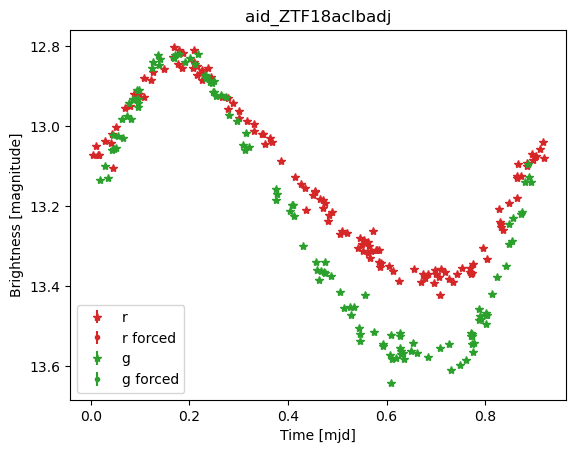

In [77]:
plot_astro_object(astro_object, unit='magnitude', use_forced_phot=True, period=period)

In [78]:
def all_features_from_astro_objects(astro_objects: List[AstroObject]) -> pd.DataFrame:
    first_object = astro_objects[0]
    features = first_object.features.drop_duplicates(subset=['name', 'fid'])
    features = features.set_index(['name', 'fid'])
    indexes = features.index.values
    
    feature_list = []
    oids = []
    for astro_object in astro_objects:
        features = astro_object.features.drop_duplicates(subset=['name', 'fid'])
        features = features.set_index(['name', 'fid'])
        feature_list.append(features.loc[indexes]['value'].values)
        
        metadata = astro_object.metadata
        oid = metadata[metadata['name'] == 'oid']['value'].values[0]
        oids.append(oid)
    
    df = pd.DataFrame(
        data=np.stack(feature_list, axis=0),
        index=oids,
        columns=['_'.join([str(i) for i in pair]) for pair in indexes]
    )
    return df

In [79]:
features_df = all_features_from_astro_objects(astro_objects)
features_df

,"g-r_mean_g,r","g-r_max_g,r",MHPS_ratio_g,MHPS_low_g,MHPS_high_g,MHPS_non_zero_g,MHPS_PN_flag_g,MHPS_ratio_r,MHPS_low_r,MHPS_high_r,...,last_brightness_before_band_r,max_brightness_before_band_r,median_brightness_before_band_r,n_forced_phot_band_after_r,max_brightness_after_band_r,median_brightness_after_band_r,Timespan_nan,Coordinate_x_nan,Coordinate_y_nan,Coordinate_z_nan
ZTF18aciiitw,0.071392,-0.008176,0.869214,203.331268,233.925446,129.0,0.0,1.381991,91.948219,66.533173,...,NaN,NaN,NaN,41.0,59.112894,-4.936426,1181.883434,0.760316,-0.649048,0.025606
ZTF18aciqhju,1.425243,2.075100,12.083539,1.417899,0.117341,66.0,0.0,13.777753,37.538624,2.724582,...,10.193029,18.911744,10.193029,228.0,26.863018,11.031358,1185.864760,0.430768,-0.618670,0.657028
ZTF18acitzrl,0.037403,-0.026968,1.104012,2777.946045,2516.228516,776.0,0.0,2.192979,5.059810,2.307277,...,NaN,NaN,NaN,24.0,29.631006,-2.559661,1209.986950,-0.045429,-0.303624,0.951708
ZTF18aciwupp,0.067683,0.080200,28.690084,0.237211,0.008268,216.0,0.0,18.942961,0.197083,0.010404,...,NaN,NaN,NaN,40.0,48.116566,4.697106,1154.965285,0.880119,-0.323208,0.347746
ZTF18acjfmvf,0.842442,0.825622,1.096938,20933.890625,19083.925781,92.0,0.0,1.071272,398.891663,372.353149,...,NaN,NaN,NaN,10.0,42.772489,2.127248,1141.962284,0.841689,-0.513617,-0.166604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZTF18acnbbbb,0.870447,0.812658,1.542459,599.217957,388.482178,229.0,0.0,1.231290,11.063259,8.985094,...,NaN,NaN,NaN,3.0,8.400938,-13.395924,1131.050888,-0.191391,0.557527,0.807795
ZTF18acnbeuu,0.340331,0.142808,6.435957,1.157401,0.179834,16.0,0.0,172.184784,5.818750,0.033794,...,7.780559,7.780559,2.490534,44.0,37.683456,17.724398,74.836283,-0.517722,0.398379,0.757138
ZTF18acnbfkb,0.527461,0.539957,2.609819,9.944693,3.810492,157.0,0.0,4.091591,34.177094,8.353008,...,NaN,NaN,NaN,115.0,95.251997,2.255433,1127.967033,-0.247135,0.423690,0.871442
ZTF18acnbfmc,0.106886,0.011464,3.503729,349.686737,99.804161,157.0,0.0,1.599167,23.397648,14.631149,...,NaN,NaN,NaN,5.0,11.256967,-6.509122,879.798494,-0.691686,0.476098,0.543048


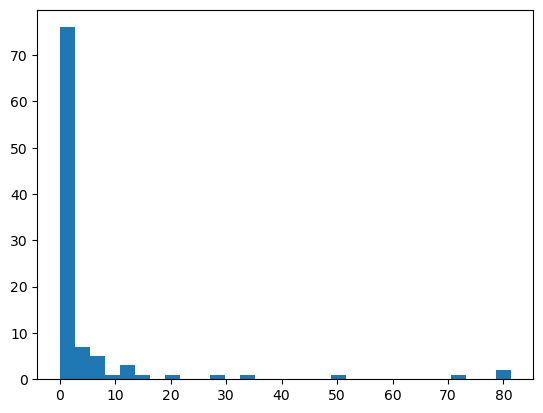

In [80]:
plt.hist(features_df['Multiband_period_g,r'].values, bins=30);

In [81]:
labels_batch = object_info.loc[features_df.index]
for alerceclass in ['DSCT', 'RRLab', 'RRLc', 'EBEW', 'EA', 'Ceph']:
    oids_class = labels_batch[labels_batch['alerceclass'] == alerceclass].index.values
    print(alerceclass, features_df.loc[oids_class]['Multiband_period_g,r'].describe())

DSCT count    7.000000
mean     0.094698
std      0.034620
min      0.053873
25%      0.069669
50%      0.089041
75%      0.114245
max      0.152141
Name: Multiband_period_g,r, dtype: float64
RRLab count    2.000000
mean     0.557738
std      0.048718
min      0.523289
25%      0.540514
50%      0.557738
75%      0.574963
max      0.592187
Name: Multiband_period_g,r, dtype: float64
RRLc count    8.000000
mean     0.344472
std      0.043273
min      0.298912
25%      0.316354
50%      0.339822
75%      0.352313
max      0.435256
Name: Multiband_period_g,r, dtype: float64
EBEW count    10.000000
mean      0.204581
std       0.067272
min       0.133550
25%       0.145593
50%       0.180672
75%       0.273974
max       0.298590
Name: Multiband_period_g,r, dtype: float64
EA count    11.000000
mean      0.751609
std       0.578683
min       0.046769
25%       0.368808
50%       0.388934
75%       1.163447
max       1.808257
Name: Multiband_period_g,r, dtype: float64
Ceph count    10.000000
m